# Notebook 3: Differential expression in time

### This exercise is based on the publication [Yang et al. (2016) "Inferring the perturbation time from biological time course data" Bioinformatics, 32(19), 2956-2964.](https://doi.org/10.1093/bioinformatics/btw329)

### We used a branching Gaussian process to identify when each gene's expression profile begins to change when comparing plants with a wild-type pathogen infection (control) to plants with a modified pathogen infection (perturbation). 

### Look at the results for some different genes - Genes 1 and 8 and from Fig. 4 in the handbook chapter and genes 6 and 19 are from Fig. 5.

Data are from Lewis et al. (2015). "Transcriptional dynamics driving MAMP-triggered immunity and pathogen effector-mediated immunosuppression in Arabidopsis leaves following infection with Pseudomonas syringae pv tomato DC3000" The Plant Cell, 27(11), 3038-3064.

Notebook created by Sumon Ahmed, Jing Yang, Magnus Rattray and Alexis Boukouvalas

In [4]:
%matplotlib inline
import matplotlib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import gpflow
import tensorflow as tf
from sklearn.preprocessing import scale
from branchingKernel import BranchKernel
from branchingKernel import plotCovarianceMatrix
tf.logging.set_verbosity(tf.logging.ERROR) # Suppresses output logs from tensorflow

## Before looking at the data, let's visualize the covariance of data from the branching GP model

Illustration of the covariance matrix, for two functions $f$ and $g$ evaluated at points evenly distributed in [0,100] and crossing at $x_p=40$ (left) and the resulting data covariance matrix, for time course data $y^c$ and $y^p$ from a wild-type and perturbed system respectively (right) 

Tensor("mul_21:0", shape=(200, 200), dtype=float64)
Tensor("add_24:0", shape=(1, 1), dtype=float64)
Tensor("invKbb_2:0", shape=(1, 1), dtype=float64)
Tensor("mul_31:0", shape=(200, 200), dtype=float64)
Tensor("add_34:0", shape=(1, 1), dtype=float64)
Tensor("invKbb_3:0", shape=(1, 1), dtype=float64)
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'SquaredExponential-84acf556-0/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/alexis/.pyenv/versions/3.6.8/envs/handbook_tutorial/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3346, in run_code
    return outflag  File "<ipython-input-2-22bcab834f8e>", line 9, in <module>
    kern = BranchKernel(gpflow.kernels.RBF(1, lengthscales=20.), xp)  File "</home/alexis/.pyenv/versions/3.6.8/envs/handbook_tutorial/lib/pyth

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'SquaredExponential-84acf556-0/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/alexis/.pyenv/versions/3.6.8/envs/handbook_tutorial/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3346, in run_code
    return outflag  File "<ipython-input-2-22bcab834f8e>", line 9, in <module>
    kern = BranchKernel(gpflow.kernels.RBF(1, lengthscales=20.), xp)  File "</home/alexis/.pyenv/versions/3.6.8/envs/handbook_tutorial/lib/python3.6/site-packages/decorator.py:decorator-gen-135>", line 2, in __init__  File "/home/alexis/.pyenv/versions/3.6.8/envs/handbook_tutorial/lib/python3.6/site-packages/gpflow/core/compilable.py", line 157, in init_wrapper
    self.initialize(force=True)  File "/home/alexis/.pyenv/versions/3.6.8/envs/

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'SquaredExponential-84acf556-0/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/alexis/.pyenv/versions/3.6.8/envs/handbook_tutorial/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3346, in run_code
    return outflag  File "<ipython-input-2-22bcab834f8e>", line 9, in <module>
    kern = BranchKernel(gpflow.kernels.RBF(1, lengthscales=20.), xp)  File "</home/alexis/.pyenv/versions/3.6.8/envs/handbook_tutorial/lib/python3.6/site-packages/decorator.py:decorator-gen-135>", line 2, in __init__  File "/home/alexis/.pyenv/versions/3.6.8/envs/handbook_tutorial/lib/python3.6/site-packages/gpflow/core/compilable.py", line 157, in init_wrapper
    self.initialize(force=True)  File "/home/alexis/.pyenv/versions/3.6.8/envs/hand

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'SquaredExponential-84acf556-0/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/alexis/.pyenv/versions/3.6.8/envs/handbook_tutorial/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3346, in run_code
    return outflag  File "<ipython-input-2-22bcab834f8e>", line 9, in <module>
    kern = BranchKernel(gpflow.kernels.RBF(1, lengthscales=20.), xp)  File "</home/alexis/.pyenv/versions/3.6.8/envs/handbook_tutorial/lib/python3.6/site-packages/decorator.py:decorator-gen-135>", line 2, in __init__  File "/home/alexis/.pyenv/versions/3.6.8/envs/handbook_tutorial/lib/python3.6/site-packages/gpflow/core/compilable.py", line 157, in init_wrapper
    self.initialize(force=True)  File "/home/alexis/.pyenv/versions/3.6.8/envs/hand

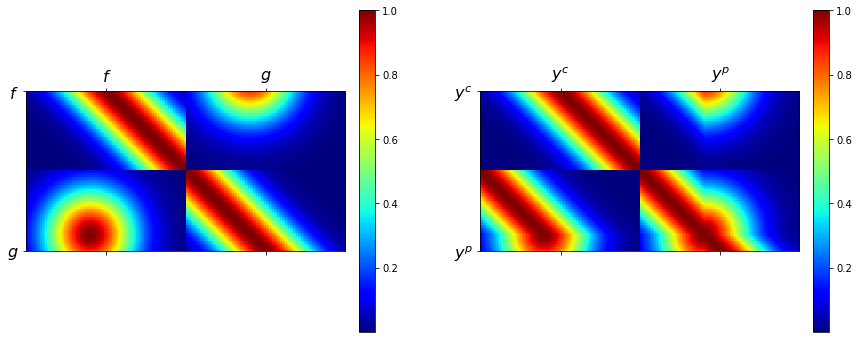

In [5]:
tc = np.linspace(0., 100., 100)[:, None]
tc = np.c_[tc, np.ones(len(tc))[:,None]]
tp = np.linspace(0., 100., 100)[:, None]
tp = np.c_[tp, (np.ones(len(tp)) * 2)[:,None]]
t = np.concatenate((tc, tp))
xp = 40. 

sess = tf.InteractiveSession()
kern = BranchKernel(gpflow.kernels.RBF(1, lengthscales=20.), xp)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.3)

covMatrix = kern.K(t)
plotCovarianceMatrix(covMatrix.eval(), ax[0], xLabel=('$f$','$g$'), yLabel=('$f$','$g$'))

t[np.where(t[:,0] <= xp),1]=1
covMatrix_DE = kern.K(t)
plotCovarianceMatrix(covMatrix_DE.eval(), ax[1], xLabel=('$y^c$','$y^p$'), yLabel=('$y^c$','$y^p$'))
sess.close()

## Load some real data from the wild-type and perturbed condition

I've only included 3 replicates to make this run a bit faster in the lab, so the results will differ a bit from those in the handbook chapter figures. We've taken the first 20 genes in the dataset. Genes 1 and 8 and from Fig. 4 in the handbook chapter and genes 6 and 19 are from Fig. 5. 

In [6]:
controlData = pd.read_csv('data/controlData3reps.csv', index_col=[0])
perturbedData = pd.read_csv('data/perturbedData3reps.csv', index_col=[0])

In [7]:
controlTimes = controlData['controlTimes'].values[:,None]
controlTimes = np.c_[controlTimes, np.ones(len(controlTimes))[:,None]]
perturbedTimes = perturbedData['perturbedTimes'].values[:,None]
perturbedTimes = np.c_[perturbedTimes, ( np.ones(len(controlTimes)) * 2 )[:,None]] 
times = np.concatenate((controlTimes, perturbedTimes))

## Let's take a look at an example - when does this gene begin to differ between the perturbed and wild-type datasets? 

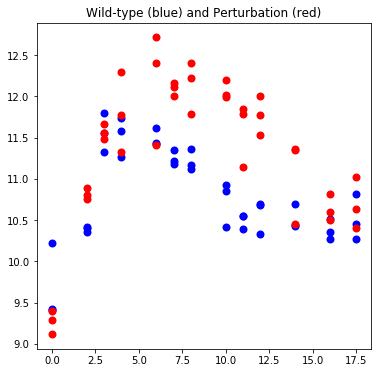

In [8]:
import matplotlib.lines as mlines
gene_id = '1' 
xc = controlTimes[:,0][:,None]
yc = controlData[gene_id].values[:,None]
xp = perturbedTimes[:,0][:,None]
yp = perturbedData[gene_id].values[:,None]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(xc, yc, 'ko', mew=2, color='b')
ax.set_title('Wild-type (blue) and Perturbation (red)')
ax.plot(xp, yp, 'ko', mew=2, color='r')
# ax[1].set_title('Perturbation')

## Before considering branching, let's check whether the gene is changing over time 

It's useful to pre-screen the genes and save a bit of computation time, as we are mainly interested in genes with measurable dynamics in the wild-type. Applying this filter is faster than applying the branching model to every gene because the branching model is applied across a grid of possible branching times. 

In [9]:
xc = controlTimes[:,0][:,None]
yc = controlData[gene_id].values[:,None]
mean_y = np.mean(yc)
sd_y = np.std(yc)
yc = scale(yc) 
Xtest = np.linspace(min(xc) - 0.5, max(xc) + 0.5, 100)

### First we fit a Gaussian process model with a squared exponential covariance

In [10]:
with gpflow.defer_build():
    mGP = gpflow.models.GPR(xc, yc, kern=gpflow.kernels.RBF(1))
mGP.compile()
opt = gpflow.train.ScipyOptimizer()
opt.minimize(mGP)                    # Optimise hyper-parameters
muGP, varGP = mGP.predict_y(Xtest)   # Predictive distribution of data
muGP = sd_y * muGP + mean_y          # Transform back to original scale
varGP = np.square(sd_y) * varGP
mGP_log_likelihood = mGP.compute_log_likelihood()       # Compute the log-likelihood

### Then we fit a constant model with only noise - this is a white noise kernel

In [11]:
with gpflow.defer_build():
    mConst = gpflow.models.GPR(xc, yc, kern=gpflow.kernels.White(1))
mConst.compile()
opt = gpflow.train.ScipyOptimizer()
opt.minimize(mConst)  
muConst, varConst = mConst.predict_y(Xtest)
muConst = sd_y * muConst + mean_y
varConst = np.square(sd_y) * varConst
mConst_log_likelihood = mConst.compute_log_likelihood()       # Compute the log-likelihood

### Plot the fit to each model

Text(0.5, 1.0, 'Constant model')

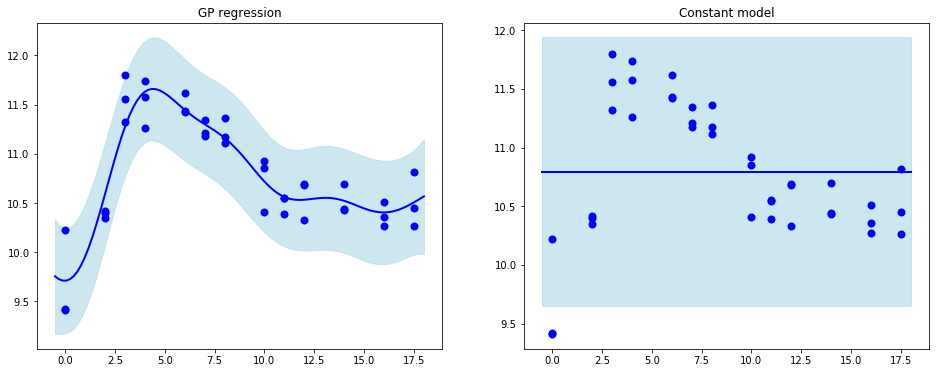

In [12]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(Xtest, muGP, '-', lw=2, color='b')
ax[0].fill_between(Xtest.reshape(-1), (muGP - 2 * np.sqrt(varGP)).reshape(-1), \
                   (muGP + 2 * np.sqrt(varGP)).reshape(-1), color='lightblue', alpha=0.6)
ax[0].plot(xc, sd_y * yc + mean_y, 'ko', mew=2, color='b')
ax[0].set_title('GP regression')

ax[1].plot(Xtest, muConst, '-', lw=2, color='b')
ax[1].fill_between(Xtest.reshape(-1), (muConst - 2 * np.sqrt(varConst)).reshape(-1), \
                   (muConst + 2 * np.sqrt(varConst)).reshape(-1), color='lightblue', alpha=0.6)
ax[1].plot(xc, sd_y * yc + mean_y, 'ko', mew=2, color='b')
ax[1].set_title('Constant model')

### The likelihood ratio quantifies whether the GP model is a better fit than the constant one

### The larger the number, the more evidence that the gene is dynamic. In practice it's useful to eyeball some genes close to zero to identify a reasonable cut-off

In [13]:
LL_ratio = mGP.compute_log_likelihood() - mConst.compute_log_likelihood() 
print(LL_ratio)

21.96448954719847


## Now use the branching GP to identify changes between two time course experiments  

In [14]:
yc = controlData[gene_id].values[:,None]
yp = perturbedData[gene_id].values[:,None]
y = np.concatenate((yc, yp))

In [15]:
N = 20 # We'll approximate the perturbation time posterior by a hitogram with 20 bins
testTimes = np.linspace(min(times[:,0]), max(times[:,0]), N) 

### Get the optimized hyperparameters

To learn the hyper-parameters we fit an independent GP model to the control and perturbation time series with shared hyper-parameters (lengthscale and variance). We can do that be putting the perturbation time (where the functions branch) very far to the left of the data. 

In [16]:
xp = -1000. # Put branching time much earlier than zero time
x = times.copy()
x[np.where(x[:,0] <= xp),1]=1
# with gpflow.settings.temp_settings(custom_config), gpflow.session_manager.get_session().as_default():
with gpflow.defer_build():
    base_kern = gpflow.kernels.RBF(1)
    k = BranchKernel(base_kern, xp)
    m = gpflow.models.GPR(x, y, kern=k)
m.compile()
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m, disp=False)

ls = m.kern.kern.lengthscales.read_value()
variance = m.kern.kern.variance.read_value()
likelihood = m.likelihood.variance.read_value()

Tensor("GPR-27924832-35/likelihood_1/mul_1:0", dtype=float64)
Tensor("GPR-27924832-35/likelihood_1/add_4:0", shape=(1, 1), dtype=float64)
Tensor("GPR-27924832-35/likelihood_1/invKbb:0", shape=(1, 1), dtype=float64)


### Fit the branching model for many different branch times so that we can use the model likelihood to calculate the posterior probability of branching at each time, using a histogram approach

In [17]:
ll = np.zeros(len(testTimes))
models = list()

for i in range(0, N):
    x = times.copy()
    x[np.where(x[:,0] <= testTimes[i]),1]=1
    with gpflow.defer_build():
        base_kernel_new = gpflow.kernels.RBF(1)
        base_kernel_new.lengthscales = ls
        base_kernel_new.variance = variance
        
        base_kernel_new.lengthscales.set_trainable(False)
        base_kernel_new.variance.set_trainable(False)
        
        k_new = BranchKernel(base_kernel_new, testTimes[i])
        m_new = gpflow.models.GPR(x, y, kern=k_new)
    m_new.compile()
    opt = gpflow.train.ScipyOptimizer()
    opt.minimize(m_new, disp=True)
    
    ll[i] = np.exp(m_new.compute_log_likelihood())
    models.append(m_new)
    del x
    del k_new
    del m_new
normalized_ll = ll / ll.sum(0)

Tensor("GPR-a6a16282-46/likelihood_1/mul_1:0", dtype=float64)
Tensor("GPR-a6a16282-46/likelihood_1/add_4:0", shape=(1, 1), dtype=float64)
Tensor("GPR-a6a16282-46/likelihood_1/invKbb:0", shape=(1, 1), dtype=float64)
Tensor("GPR-84796a1a-57/likelihood_1/mul_1:0", dtype=float64)
Tensor("GPR-84796a1a-57/likelihood_1/add_4:0", shape=(1, 1), dtype=float64)
Tensor("GPR-84796a1a-57/likelihood_1/invKbb:0", shape=(1, 1), dtype=float64)
Tensor("GPR-523ec483-68/likelihood_1/mul_1:0", dtype=float64)
Tensor("GPR-523ec483-68/likelihood_1/add_4:0", shape=(1, 1), dtype=float64)
Tensor("GPR-523ec483-68/likelihood_1/invKbb:0", shape=(1, 1), dtype=float64)
Tensor("GPR-4698f2a5-79/likelihood_1/mul_1:0", dtype=float64)
Tensor("GPR-4698f2a5-79/likelihood_1/add_4:0", shape=(1, 1), dtype=float64)
Tensor("GPR-4698f2a5-79/likelihood_1/invKbb:0", shape=(1, 1), dtype=float64)
Tensor("GPR-3b5f1b51-90/likelihood_1/mul_1:0", dtype=float64)
Tensor("GPR-3b5f1b51-90/likelihood_1/add_4:0", shape=(1, 1), dtype=float64)
Te

In [18]:
iMAP = np.argmax(ll)
MAP_model = models[iMAP]

### We will show the GP regression fit for the model with the maximum posterior (MAP) perturbation time 

In [19]:
Xnew = np.linspace(min(times[:,0]) - 0.5, max(times[:,0]) + 0.5, 100)[:, None]
x1 = np.c_[Xnew, np.ones(len(Xnew))[:, None]]
x2 = np.c_[Xnew, ( np.ones(len(Xnew)) * 2 )[:, None]]
Xtest = np.concatenate((x1, x2))
Xtest[np.where(Xtest[:,0] <= testTimes[iMAP]),1]=1

In [20]:
mu, var = MAP_model.predict_y(Xtest)
upper = mu+2*np.sqrt(var)
lower = mu-2*np.sqrt(var)

Tensor("autoflow/GPR/predict_y_2/predict/mul_1:0", dtype=float64)
Tensor("autoflow/GPR/predict_y_2/predict/add_4:0", shape=(1, 1), dtype=float64)
Tensor("autoflow/GPR/predict_y_2/predict/invKbb:0", shape=(1, 1), dtype=float64)
Tensor("autoflow/GPR/predict_y_2/predict/mul_10:0", dtype=float64)
Tensor("autoflow/GPR/predict_y_2/predict/add_13:0", shape=(1, 1), dtype=float64)
Tensor("autoflow/GPR/predict_y_2/predict/invKbb_1:0", shape=(1, 1), dtype=float64)


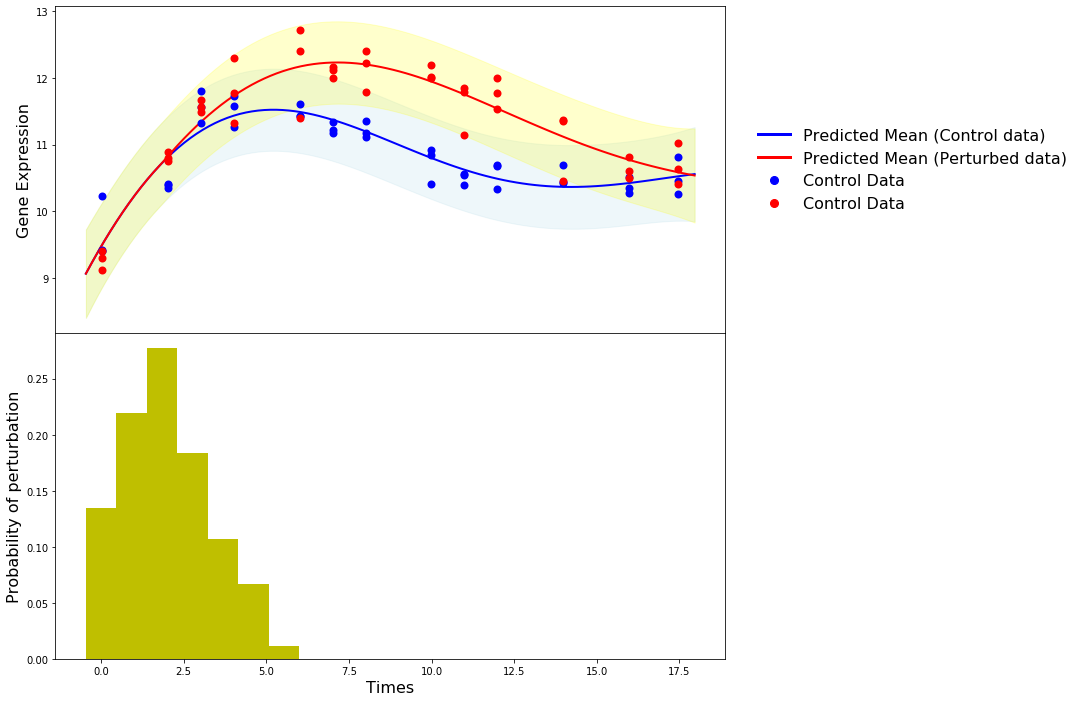

In [21]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

ax[0].plot(Xnew, mu[0:100,:], '-', lw=2, color='b')
ax[0].fill_between(Xnew.reshape(-1), lower[0:100, :].reshape(-1), upper[0:100, :].reshape(-1), color='lightblue', alpha=0.2)

ax[0].plot(Xnew, mu[100:200,:], '-', lw=2, color='r')
ax[0].fill_between(Xnew.reshape(-1), lower[100:200, :].reshape(-1), upper[100:200, :].reshape(-1), color='yellow', alpha=0.2)

ax[0].plot(controlTimes[:,0], yc, 'ko', mew=2, color='b')
ax[0].plot(perturbedTimes[:,0], yp, 'ko', mew=2, color='r')
ax[0].set_ylabel('Gene Expression', fontsize=16)

blue_line = mlines.Line2D([], [], color='blue', linewidth=3., label='Predicted Mean (Control data)')
red_line = mlines.Line2D([], [], color='red', linestyle='-', linewidth=3., label='Predicted Mean (Perturbed data)')
blue_dot = mlines.Line2D([], [], color='blue', marker='o', markersize='8', linestyle='', label='Control Data')
red_dot = mlines.Line2D([], [], color='red', marker='o', markersize='8', linestyle='', label='Control Data')
ax[0].legend(handles=[blue_line, red_line, blue_dot, red_dot], bbox_to_anchor=(1.28, 0.5), loc=10, fontsize=16, frameon=False)

width = testTimes[1]-testTimes[0]
ax[1].bar(testTimes, normalized_ll, color='y', align='center', edgecolor = "none", width=width)
ax[1].set_xlabel('Times', fontsize=16)
ax[1].set_ylabel('Probability of perturbation', fontsize=16)
plt.subplots_adjust(wspace=0, hspace=0)